In [10]:
from pygraph.classes.graph import graph
from pygraph.readwrite import dot
from pygraph.algorithms.minmax import shortest_path
from pygraph.algorithms.accessibility import connected_components
from pygraph.algorithms.pagerank import pagerank

In [11]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [21]:
import itertools
import random
import statistics

In [7]:
from network import *

In [14]:
from IPython.core.display import Image, display

In [12]:
def construct_graph_filtered(old_graph, node_predicate, egde_predicate):
    new_graph = graph()
    for node in old_graph.nodes():
        if node_predicate(node):
            new_graph.add_node(node)
    for edge in old_graph.edges():
        if not new_graph.has_edge(edge):
            if node_predicate(edge[0]) and node_predicate(edge[1]) and egde_predicate(edge):
                new_graph.add_edge(edge)
    return new_graph

In [2]:
def load_authors_dataset(filename):
    f = open(filename, 'r')
    for line in f:
        [journal, title, authors, year, abstract] = line.split("\t")
        yield Article(title, authors.split(",") if authors != "" else [], year, journal, abstract, None, [])    

In [5]:
def parse_dataset_file(filename):
    paper_title_regexp = re.compile('#\*(.*)\n')
    authors_regexp = re.compile('#@(.*)\n')
    year_regexp = re.compile('#t(.*)\n')
    publication_venue_regexp = re.compile('#c(.*)\n')
    paper_index_regexp = re.compile('#index(.*)\n')
    references_ids_regexp = re.compile('#%(.*)\n')
    
    f = open(filename, 'r')
    
    paper_title = authors = publication_venue = paper_index_id = ''
    year = -1
    references_ids = []
    
    for line in f:
        if paper_title_regexp.search(line) is not None:
            paper_title = paper_title_regexp.search(line).group(1)
        elif authors_regexp.search(line) is not None:
            authors = authors_regexp.search(line).group(1)
        elif year_regexp.search(line) is not None:
            year = year_regexp.search(line).group(1)
        elif publication_venue_regexp.search(line) is not None:
            publication_venue = publication_venue_regexp.search(line).group(1)
        elif paper_index_regexp.search(line) is not None:
            paper_index = paper_index_regexp.search(line).group(1)
        elif references_ids_regexp.search(line) is not None:
            references_ids.append(references_ids_regexp.search(line).group(1))
        elif line == "\n":
            yield Article(paper_title, authors.split(",") 
                          if authors != '' else [], year, publication_venue, paper_index, None, references_ids)
            paper_title = authors = publication_venue = paper_index_id = ''
            year = -1
            references_ids = []

In [8]:
def analyse(file, loader):
    coauthorNetwork = CoauthorNetwork()
    for article in loader(file):
        coauthorNetwork.add_article(article)

    print("Uniq authors:", len([x for x in coauthorNetwork.author_to_article.keys()]))
    return coauthorNetwork
    
#file = "./data/authors/Medical Informatics.txt"
file = "./data/out_test.txt"
coauthorNetwork = analyse(file, parse_dataset_file)
components = connected_components(coauthorNetwork.gr)


#!dot 'graph.dot' -Tpng -o "graph.png"
#display(Image('graph.png' ))

Uniq authors: 18335


In [14]:
# calculate distance distribution for 
# detect small world phenomenon
def get_distance_stat(graph, n):
    stat = {}
    summ = len(graph.nodes()) * n
    for i in range(n): # iterative calculation of shortest path
        random_author = random.choice(graph.nodes())
        distances = shortest_path(graph, random_author)[1]
        for x in distances.values():
            stat[x] = stat.get(x, 0) + 1;
    return dict( (key, value / summ) for key, value in stat.items() )
        

In [25]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [38]:
import networkx as nx
#calculate centrality statistics
def get_centrality_stat(graph):
    N = 10
    centrality_stat = nx.degree_centrality(graph)
    print("----------")
    print("Average degree node centrality:", sum(centrality_stat.values())/len(centrality_stat) )
    
    max_centrality = max(centrality_stat.values())
    print("Maxumum degree node centrality:", max_centrality)
    
    nodes_num = len(graph.nodes())
    print("Degree graph centrality:", 
          sum([max_centrality - x for x in centrality_stat.values()])/((nodes_num - 1)*(nodes_num - 2)))
    
    print("----------")
    
    return dict((key, centrality_stat.get(key)) for key in take(N, centrality_stat) )
        

In [2]:
def calc_pagerank(graph):
    TOP = 10
    percent_threshold = 0.1
    weighted_nodes = pagerank(graph)
    sorted_authors = sorted(weighted_nodes.items(), key = lambda pair: -pair[1])
    author_rank = dict( (val, idx) for idx, val in enumerate(sorted_authors.keys()))
    threshold = author_rank[round(len(author_rank) * percent_threshold )]
    top_subgraph = construct_graph_filtered
    
    

In [30]:
def analize_components(coauthorNetwork, components, component_num):
    print("----------")
    print("Component:", component_num)
    PRECISION = 50 # number of authors to calc avg distance

    component_sizes = {}

    for author, component in components.items():
        component_sizes[component] = component_sizes.get(component, 0) + 1

    top10_components = sorted(component_sizes.items(), key = lambda pair: -pair[1])[0:10]

    top1_component = top10_components[component_num][0]

    top1_subgraph = construct_graph_filtered(coauthorNetwork.gr,
                                             lambda node: components[node] == top1_component,
                                             lambda egde: True)
    
    print("Authors count:",len(top1_subgraph.nodes()))
    stat = get_distance_stat(top1_subgraph, PRECISION)
    cstat = get_centrality_stat(coauthorNetwork.cgr)
    print("Degree Nodes Centrality (first N elements):", cstat)
    #print(stat)
    print("Mean distance:", sum([value * key for key, value in stat.items()]))
    plt.plot([x for x in stat.keys()], [x for x in stat.values()])
    plt.show()


In [6]:
weighted_nodes = pagerank(coauthorNetwork.gr)

AttributeError: 'graph' object has no attribute 'incidents'

In [10]:
def run_analyse(file):
    print("Dataset:", file)
    coauthorNetwork = analyse(file, parse_dataset_file)
    components = connected_components(coauthorNetwork.gr)
    component_count = max(components.values())
    print("Connected component count:", component_count)
    analize_components(coauthorNetwork, components, 0)
    analize_components(coauthorNetwork, components, 1)

Dataset: ./data/out_test.txt
Uniq authors: 185015
Connected component count: 44853
----------
Component: 0
Authors count: 72701
----------
Average degree node centrality:  9.628596297572231e-06
Maxumum degree node centrality:  0.0011385612725737476
Degree graph centrality:  6.150110186737271e-09
----------
Degree Centrality: {'56662': 2.1790646365047802e-05, '287454': 5.4476615912619505e-06, '60017': 0.0, '91633': 5.4476615912619505e-06, '42453': 0.0, '370392': 1.0895323182523901e-05, '22209': 1.6342984773785853e-05, '486293': 5.4476615912619505e-06, '91220': 0.0, '34242': 0.0}
Mean distance: 8.673449883770516


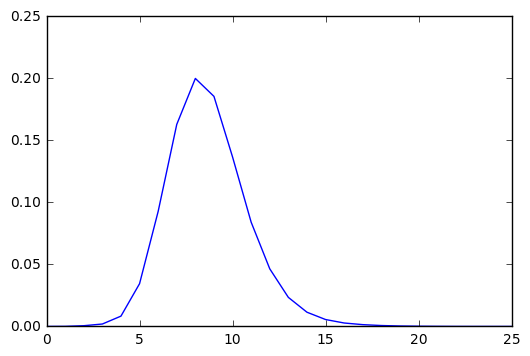

----------
Component: 1
Authors count: 162
----------
Average degree node centrality:  9.628596297572231e-06
Maxumum degree node centrality:  0.0011385612725737476
Degree graph centrality:  6.150110186737271e-09
----------
Degree Centrality: {'56662': 2.1790646365047802e-05, '287454': 5.4476615912619505e-06, '60017': 0.0, '91633': 5.4476615912619505e-06, '42453': 0.0, '370392': 1.0895323182523901e-05, '22209': 1.6342984773785853e-05, '486293': 5.4476615912619505e-06, '91220': 0.0, '34242': 0.0}
Mean distance: 4.898641975308642


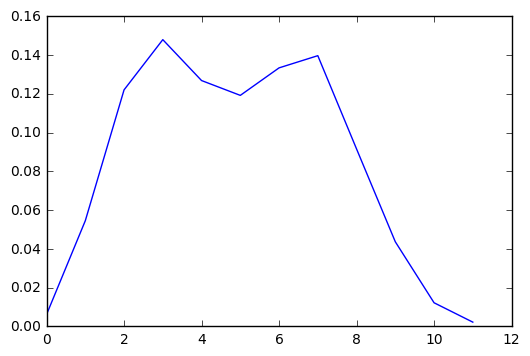

In [40]:
run_analyse("./data/out_test.txt")
#run_analyse("./data/authors/Database.txt")
#run_analyse("./data/authors/Data Mining.txt")
#run_analyse("./data/authors/Theory.txt")
#run_analyse("./data/authors/Visualization.txt")


In [15]:
a = [1,2,3,4,5,6,7,8,9,10,11]
a[:round(len(a) * 0.4)]

[1, 2, 3, 4]